# Project 1 Report

#### Joosep Orasmäe, Kaupo Humal, Tanel Tiisler, Kalju Jake Nekvasil

## Initialization

This section is for importing libraries and visualizing the dataset. 

In [10]:
from pyspark.sql import SparkSession

spark = (SparkSession.builder
                    .appName('project1')
                    .getOrCreate()
        )

In [11]:
from pyspark.sql.functions import *
from pyspark.sql import Window
from shapely.geometry import Point, Polygon
from shapely import from_wkt
from pyspark.sql.types import *

In [12]:
#original, unmodified dataset
raw_rides_df = (spark.read
             .option("sep", ",") # separator
             .option("header", True) # file has header row
             .option("inferSchema", True) # spark tries to infer data types
             .csv("input/Sample NYC Data.csv") #path
            )

In [13]:
raw_rides_df.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [14]:
raw_rides_df.show()

+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|           medallion|        hack_license|vendor_id|rate_code|store_and_fwd_flag|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|
+--------------------+--------------------+---------+---------+------------------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+
|89D227B655E5C82AE...|BA96DE419E711691B...|      CMT|        1|                 N| 01-01-13 15:11|  01-01-13 15:18|              4|      -73.978165|      40.757977|       -73.989838|       40.751171|
|0BD7C8F5BA12B88E0...|9FD8F69F0804BDB55...|      CMT|        1|                 N| 06-01-13 00:18|  06-01-13 00:22|              1|      -74.006683|      40.731781|       -73.994499|        40.75066|


## Preprocessing

- Remove irrelevant columns
- Remove illogical values
- Enrich data

In [15]:
# Use the unix_timestamp function to convert the date time of the respective times into milliseconds
DATETIME_FORMAT = "dd-MM-yy HH:mm"

rides_df = raw_rides_df.select( #fields of interest, according to HW description
    "medallion",
    "hack_license",
    "pickup_datetime",
    "dropoff_datetime",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude"
)

rides_df = rides_df.withColumn("pickup_unix", unix_timestamp("pickup_datetime", DATETIME_FORMAT)) \
                   .withColumn("dropoff_unix", unix_timestamp("dropoff_datetime", DATETIME_FORMAT))

# Subtract the times to find the difference (in seconds)
rides_df = rides_df.withColumn("duration_sec", rides_df["dropoff_unix"] - rides_df["pickup_unix"])

rides_df = rides_df.select( #remove already converted fields 
    "medallion",
    "hack_license",
    "pickup_unix",
    "dropoff_unix",
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "duration_sec"
)

In [16]:
#removing impossible data rows, where client was picked up, before last client was dropped off.

#rides_df = rides_df.orderBy("hack_license", "pickup_datetime") #unneccesary, as windowspec handles it well:)
windowSpec = Window.partitionBy("medallion").orderBy("pickup_unix")
test_df = rides_df.withColumn("prev_dropoff", lag("dropoff_unix").over(windowSpec))
overlaps = test_df.filter(col("pickup_unix") < col("prev_dropoff"))
#print(overlaps.count()) #15 concrete overlaps or 1175 including equals
# partionby hack_license gives exact same overlaps.
rides_df = test_df.filter(col("pickup_unix") >= col("prev_dropoff"))

#removing most likely wrong results, where single drive took over 4 hours.
DURATION_THRESHOLD = 14400 # 4 hours in seconds
rides_df = rides_df.filter((col("duration_sec") >= 0) & (col("duration_sec") <= DURATION_THRESHOLD))


In [17]:
#enrich dataset with geodata, to filter out coordinates out of NY. 
#most errors come from latitude == longitude == 0, most likely default for uninserted data

geo_df = (spark.read.option("multiline", "true").json("input/nyc-boroughs.geojson")).select(explode("features").alias("borough"))\
        .select(col("borough.geometry").alias("geometry"),
                col("borough.properties.borough").alias("borough_name"),
                col("borough.properties.boroughCode").alias("borough_code"))

#wkt serializes the geometry so we can store it as a string
geo_to_poly_udf = udf(lambda geo: Polygon(geo["coordinates"][0]).wkt, returnType=StringType())
geo_to_area_udf = udf(lambda geo: Polygon(geo["coordinates"][0]).area, returnType=DoubleType())
coords_to_point_udf = udf(lambda coords: Point(coords[0], coords[1]).wkt, returnType=StringType()) # For the main dataframe
is_point_in_polygon_udf = udf(lambda point_wkt, polygon_wkt: from_wkt(polygon_wkt).contains(from_wkt(point_wkt)), BooleanType())

geo_df = geo_df.withColumn("poly", geo_to_poly_udf(col("geometry"))). \
        withColumn("area", geo_to_area_udf(col("geometry"))). \
        drop("geometry"). \
        orderBy("borough_code", desc("area"))

#geo_df.printSchema()
geo_df.show()

+------------+------------+--------------------+--------------------+
|borough_name|borough_code|                poly|                area|
+------------+------------+--------------------+--------------------+
|   Manhattan|           1|POLYGON ((-73.926...|0.005859077996035753|
|   Manhattan|           1|POLYGON ((-73.921...|2.327165585676201...|
|   Manhattan|           1|POLYGON ((-74.016...|  7.6037752599342E-5|
|   Manhattan|           1|POLYGON ((-73.941...| 6.23157479510608E-5|
|   Manhattan|           1|POLYGON ((-73.906...|3.265859127204495...|
|   Manhattan|           1|POLYGON ((-74.039...|1.182888313767709...|
|   Manhattan|           1|POLYGON ((-74.043...|6.143638903459381E-6|
|   Manhattan|           1|POLYGON ((-73.995...|3.383127367444441...|
|   Manhattan|           1|POLYGON ((-74.001...|2.858823502476497E-6|
|   Manhattan|           1|POLYGON ((-74.000...|2.393654308790746E-6|
|   Manhattan|           1|POLYGON ((-74.001...|2.334554077223592...|
|   Manhattan|      

In [18]:

rides_df = rides_df.withColumn("pickup_point", coords_to_point_udf(array("pickup_longitude", "pickup_latitude"))) \
    .withColumn("dropoff_point", coords_to_point_udf(array("dropoff_longitude", "dropoff_latitude"))) \
    .drop("pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude")
borough_lookup = spark.sparkContext.broadcast(geo_df.collect())

# UDF to find borough for a given point
find_borough_udf = udf(lambda point_wkt: 
    next((b['borough_name'] for b in borough_lookup.value
          if point_wkt and from_wkt(b['poly']).contains(from_wkt(point_wkt))),
         "N/A"),
    StringType()
)
# Add pickup and dropoff borough columns
rides_df = rides_df.withColumn("pickup_borough", find_borough_udf(col("pickup_point"))) \
                    .withColumn("dropoff_borough", find_borough_udf(col("dropoff_point")))
rides_df.show()

#remove wronf areas / coordinates out of NY 
rides_df = rides_df.filter(
    (col("pickup_borough") != "N/A") & (col("dropoff_borough") != "N/A")
)
rides_df = rides_df.select( #point info is no longer needed
    "medallion",
    "hack_license",
    "pickup_unix",
    "dropoff_unix",
    "prev_dropoff",
    "pickup_borough",
    "dropoff_borough",
    "duration_sec"
    )
rides_df.cache()
rides_df.show()


+--------------------+--------------------+-----------+------------+------------+------------+--------------------+--------------------+--------------+---------------+
|           medallion|        hack_license|pickup_unix|dropoff_unix|duration_sec|prev_dropoff|        pickup_point|       dropoff_point|pickup_borough|dropoff_borough|
+--------------------+--------------------+-----------+------------+------------+------------+--------------------+--------------------+--------------+---------------+
|002E3B405B6ABEA23...|D21C217C79D8E1E27...| 1358049900|  1358051700|        1800|  1358048340|POINT (-73.990074...|POINT (-74.008774...|     Manhattan|      Manhattan|
|002E3B405B6ABEA23...|D21C217C79D8E1E27...| 1358052180|  1358052720|         540|  1358051700|POINT (-74.004333...|POINT (-73.987373...|     Manhattan|      Manhattan|
|002E3B405B6ABEA23...|186DB365E8D766C78...| 1358079060|  1358080920|        1860|  1358052720|POINT (-73.78923 ...|POINT (-73.987122...|        Queens|      Man

## Query 1

In this query we calculate utilization per taxi/driver.

In [10]:
# Re-declare 4 hour threshold
DRIVER_SESSION_LENGTH = 14400 # 4 hours in seconds
# Sort by driver ID and pickup time so trips for each driver are in chronological order 
#q1_df = rides_df.orderBy("hack_license", "pickup_datetime")

# Separate data by driver and order by pickup time
#window_spec = Window.partitionBy("hack_license").orderBy("pickup_unix")

# Include previous dropoff time and idle time (if idle time is < 4 hours, else 0)
rides_df = rides_df.withColumn("idle_time_sec", 
                               when((col("pickup_unix") - col("prev_dropoff")) < DRIVER_SESSION_LENGTH,
                                    col("pickup_unix") - col("prev_dropoff"))
                               .otherwise(0))

# Filter out rows with 0 idle_time, group by driver id, sum total idle time for each driver
idle_time_df = rides_df.filter(col("idle_time_sec") > 0) \
                       .groupBy("hack_license") \
                       .sum("idle_time_sec") \
                       .withColumnRenamed("sum(idle_time_sec)", "total_idle_time_sec")
# Output table of total IDLE time per driver
idle_time_df.show()

+--------------------+-------------------+
|        hack_license|total_idle_time_sec|
+--------------------+-------------------+
|F82F2D204CF1C46A0...|               8400|
|947188A407BD268A1...|              13800|
|0E10C5D6B0E2D6E8A...|               3120|
|C8D349DC61BCD170E...|              21840|
|1F0477B7D3D6875E9...|               5700|
|E068AB00893B201EF...|                840|
|8B36DB23030FADC26...|               3540|
|483C1649342D0F0DF...|               5160|
|87D96A0E5D07050E2...|               9420|
|28EDC56C602EFFD20...|               8100|
|79424BE1D08B22D18...|              19980|
|F3DC889B956BA8AE3...|               9600|
|964BBE98ACEB562E3...|               8520|
|FC7A9C509F604338E...|              23340|
|03FDF6D5A6377FAED...|              13860|
|26516CD746248B349...|               3240|
|A2FBB7823446266EC...|              30600|
|68BD97EA39D32B9D0...|               5340|
|43642DE3866FA9B46...|               7620|
|2CB3F9DFF22D79C50...|              15360|
+----------

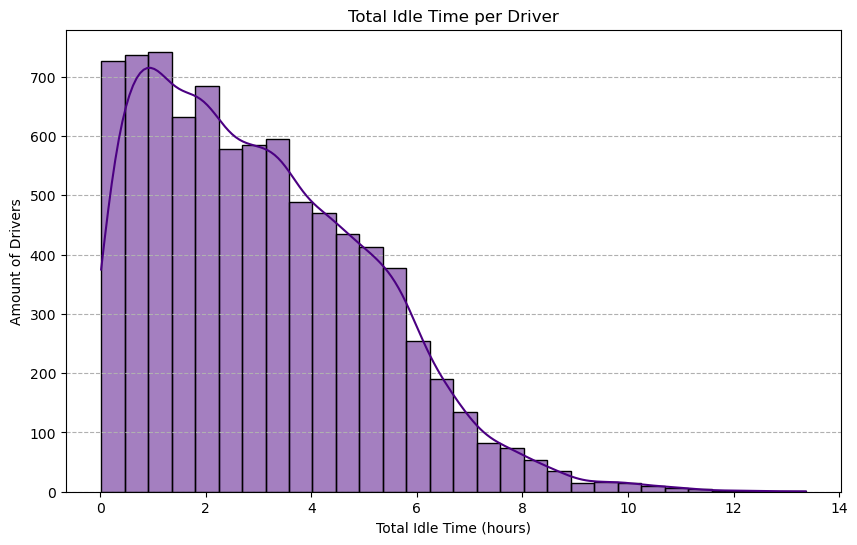

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to Pandas
idle_time_pd = idle_time_df.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(idle_time_pd['total_idle_time_sec'] / 3600, bins=30, kde=True, color='indigo')
plt.title('Total Idle Time per Driver')
plt.xlabel('Total Idle Time (hours)')
plt.ylabel('Amount of Drivers')
plt.grid(axis='y', linestyle='--')
plt.show()

### Analysis

The majority of drivers have a low total idle time of less than 4 hours between trips. However, these numbers are not entirely helpful in determining a driver's efficiency as they don't take into account each driver's total time worked. Calculating the utilization rate will resolve this issue.

In [21]:
# Calc total ACTIVE times by summing all ride durations (for each driver)

# Subtract the times to find the difference (in seconds)

active_time_df = rides_df.groupBy("hack_license") \
                        .sum("duration_sec") \
                        .withColumnRenamed("sum(duration_sec)", "total_active_time_sec")

# Join with IDLE time data
driver_times_df = active_time_df.join(idle_time_df, "hack_license")

# Calc total SESSION times by summing idle and ACTIVE times
# Calc utilization rate difference: ACTIVE/SESSION
utilization_df = driver_times_df.withColumn(
    "total_session_time", 
    col("total_active_time_sec") + col("total_idle_time_sec")
).withColumn(
    "utilization_rate", 
    col("total_active_time_sec") / col("total_session_time")
)

# Output sorted table for verification
utilization_df.select("hack_license", "utilization_rate").orderBy("utilization_rate", ascending=False).show()

+--------------------+------------------+
|        hack_license|  utilization_rate|
+--------------------+------------------+
|31A1F192A01B30B2C...|0.9814814814814815|
|7E73B38D829AA77F2...|0.9807692307692307|
|3836463623075CCF1...|0.9782608695652174|
|B24D87EA86C349F5B...| 0.975609756097561|
|1735076F27B86A649...|0.9743589743589743|
|751EE304AD669A5C9...|0.9714285714285714|
|D57EC7DC90ABE6176...| 0.967741935483871|
|25D94112137704AE1...|0.9672131147540983|
|06150B4FF9CD737D0...|0.9666666666666667|
|5DE0F6ED31F876A28...|0.9666666666666667|
|56F5F59C3EC8ACA1F...|0.9655172413793104|
|3481A161C5790DB73...|0.9649122807017544|
|B708C3D9C585DA845...|0.9642857142857143|
|1603132156F27D303...|0.9629629629629629|
|AB2569908ED389C92...|0.9629629629629629|
|C0EE8542372531D13...|0.9629629629629629|
|D2B62DA36478DEB1B...|0.9629629629629629|
|0A647BD0A85083CD1...|0.9607843137254902|
|0772E85CB3C3FB46F...|0.9583333333333334|
|BA510F229E9E7E292...|0.9565217391304348|
+--------------------+------------

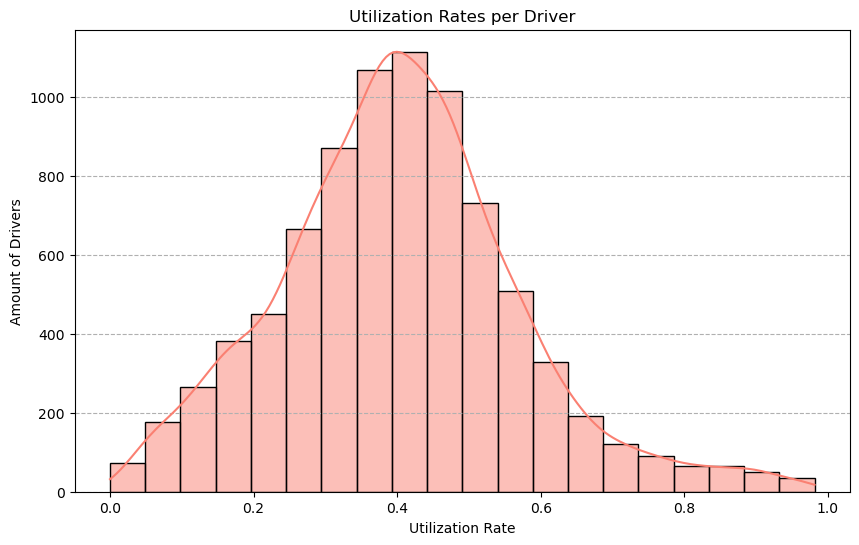

In [23]:
# Convert to Pandas for easier plotting
utilization_pd = utilization_df.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(utilization_pd['utilization_rate'], bins=20, kde=True, color='salmon')
plt.title('Utilization Rates per Driver')
plt.xlabel('Utilization Rate')
plt.ylabel('Amount of Drivers')
plt.grid(axis='y', linestyle='--')
plt.show()

### Analysis

Calculating utilization rate gives us a much better picture of each driver's efficiency. The average driver has a utilization rate of around 0.4 meaning that only ~40% of their time working is spent on active trips. This data could be further divided into hours worked showing the average efficiency per time worked. I.e. How efficient is it to work long hours vs. short hours?

## Query 2

In this query we calculate the average time it takes for a taxi to find its next fare(trip) per destination borough.

*The difference (in seconds) between the drop off of a trip and the pick up of the next trip*

In [12]:
window_spec = Window.partitionBy("hack_license").orderBy("pickup_unix")
# Calc next fare time by borough - Filter out nulls and 4 hours
next_fare_df = rides_df.withColumn("next_pickup_unix", 
                                  lead("pickup_unix").over(window_spec)) \
                       .withColumn("next_fare_time", 
                                  when(col("next_pickup_unix").isNotNull(), 
                                       col("next_pickup_unix") - col("dropoff_unix"))
                                  .otherwise(None)) \
                       .filter(col("next_fare_time").isNotNull() & 
                              (col("next_fare_time") <= DRIVER_SESSION_LENGTH))

# Calc avg. next fare time by dropoff borough and sort
avg_next_fare_by_borough = next_fare_df.groupBy("dropoff_borough") \
                                       .agg(avg("next_fare_time").alias("avg_next_fare_time_sec")) \
                                       .orderBy("avg_next_fare_time_sec")

# Show results
avg_next_fare_by_borough.show()

+---------------+----------------------+
|dropoff_borough|avg_next_fare_time_sec|
+---------------+----------------------+
|      Manhattan|     857.0868687401855|
|       Brooklyn|    1942.4757505773673|
|          Bronx|    2081.3076923076924|
|         Queens|    2617.9843285598486|
|  Staten Island|                4350.0|
+---------------+----------------------+



## Query 3

The number of trips that started and ended within the same borough

In [13]:
# Query 3. The number of trips that started and ended within the same borough
same_borough_trips = rides_df.filter(col("pickup_borough") == col("dropoff_borough"))

# Count those trips
total_same_borough = same_borough_trips.count()


In [14]:
total_same_borough

81432

## Query 4

The number of trips that started and ended within the same borough

In [15]:
# Query 4. The number of trips that started in one borough and ended in another one

rides_df.count() - total_same_borough

9864